In [28]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
import numpy as np
from PIL import Image
import torch
import pandas as pd
import os
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split

In [29]:
# 图片和数据文件的路径
image_dir = r"E:\picturedataplussssss1/"
train_data_file = r"E:\pic_diffusion_vae/train_data.xlsx"
test_data_file = r"E:\pic_diffusion_vae/test_data.xlsx"

# 读取 Excel 文件
train_df = pd.read_excel(train_data_file, nrows=13000)
test_df = pd.read_excel(test_data_file, nrows=3500)

class CustomDataset(Dataset):
    def __init__(self, images_dir, dataframe):
        self.images_dir = images_dir
        self.dataframe = dataframe
        self.transform = transforms.Compose([
            transforms.Resize(224, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])
        
        
        
    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = f"lcy{self.dataframe.iloc[idx, 0]}.jpg"
        img_path = os.path.join(self.images_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        image = self.transform(image)
        conditions = torch.tensor(self.dataframe.iloc[idx, 3:4].values, dtype=torch.float)

        
        return {'pixel_values': image, 'input_ids': conditions}

# 创建数据集实例
#dataset = CustomDataset(image_dir, data_df)




train_dataset = CustomDataset(image_dir, train_df)
test_dataset = CustomDataset(image_dir, test_df)


# 设置设备（CPU 或 GPU）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# 创建 DataLoader
#dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)
# 获取并打印第一批数据的形状
#for batch in dataloader:
#    pixel_values = batch['pixel_values']
#    input_ids = batch['input_ids']
#    print("Batch pixel_values shape:", pixel_values.shape)
#    print("Batch input_ids shape:", input_ids)
#    break

In [30]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import r2_score
# 定义 collate_fn 函数
def collate_fn(data):
    pixel_values = [i['pixel_values'] for i in data]
    input_ids = [i['input_ids'] for i in data]

    # 将列表的数据堆叠成一个新的Tensor，并转移到设备上
    pixel_values = torch.stack(pixel_values).to(device)
    input_ids = torch.stack(input_ids).to(device)
    
    return {'pixel_values': pixel_values, 'input_ids': input_ids}

# 创建 DataLoader 实例
train_loader = DataLoader(train_dataset, shuffle=True, collate_fn=collate_fn, batch_size=64, num_workers=0)
test_loader = DataLoader(test_dataset, shuffle=False, collate_fn=collate_fn, batch_size=64, num_workers=0)

# 创建 DataLoader 实例
#loader = DataLoader(dataset,
#                    shuffle=True,
#                    collate_fn=collate_fn,
#                    batch_size=32,
#                    num_workers=0)  # 可以根据实际情况调整 num_workers|

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F



import torch
import torch.nn as nn
import torch.nn.functional as F

# 定义模型
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.AvgPool2d(kernel_size=2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.AvgPool2d(kernel_size=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.AvgPool2d(kernel_size=2)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.AvgPool2d(kernel_size=2)

        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.pool5 = nn.AvgPool2d(kernel_size=2)

        self.flatten = nn.Flatten()

        # 计算池化后的尺寸（假设输入图像尺寸为224x224）
        # 经过五次2x2的池化操作后，图像尺寸为 (224 / 2 / 2 / 2 / 2 / 2) = 7
        self.fc1 = nn.Linear(512 * 7 * 7, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 128)
        self.fc4 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)

        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool4(x)

        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool5(x)

        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# 初始化模型
model = CNN()

# 加载模型权重，并调整为单GPU或CPU格式
def load_model(model, model_path):
    # 加载保存的状态字典
    state_dict = torch.load(model_path)


    # 加载调整后的状态字典
    model.load_state_dict(state_dict)

# 加载模型并进行推断
model_path = "E:\pic_diffusion_vae\predictmodel/CNN_parametersC33Best.pth"
load_model(model, model_path)


In [32]:
model.requires_grad_(False)
model.eval()
model.to(device)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d

50
0.9308031785296162
0.17677265


D:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 29702 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 24819 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 32447 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 29702 missing from current font.
  font.set_text(s, 0, flags=flags)
D:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 24819 missing from current font.
  font.set_text(s, 0, flags=flags)
D:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 32447 missing from current font.
  font.set_text(s, 0, flags=flags)


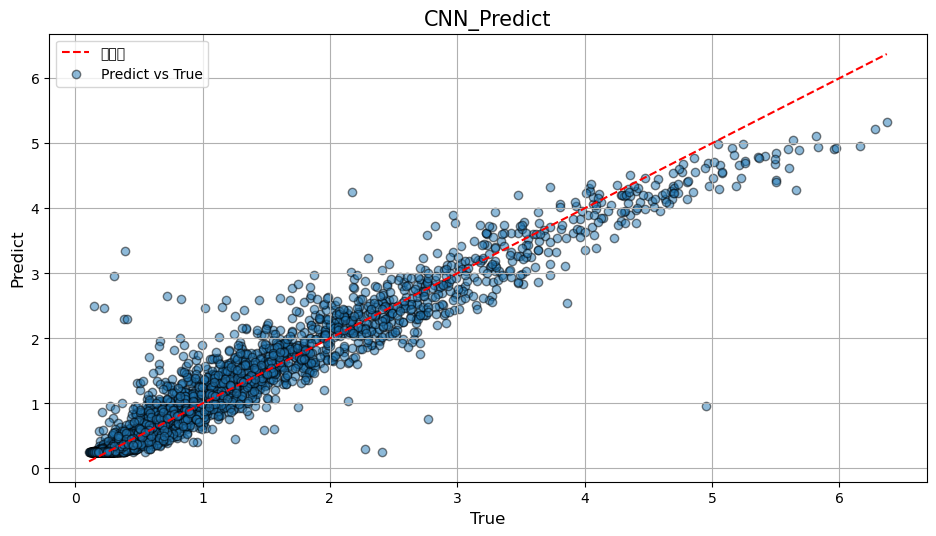

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error
model.eval()

model.to(device)

true_values = []
predicted_values = []
print(len(test_loader))
# 遍历测试数据集并收集真实值和预测值
with torch.no_grad():
    for batch in test_loader:
        inputs, targets = batch['pixel_values'].to(device), batch['input_ids'].to(device)

        # 前向传播
        output = model(inputs)
        
        # 将输出从Tensor转换为numpy数组并收集
        predicted_values.extend(output.cpu().numpy().flatten())
        true_values.extend(targets.cpu().numpy().flatten())
        
# 将预测值和真实值保存到Excel文件中
df = pd.DataFrame({
    'True Values': true_values,
    'Predicted Values': predicted_values
})
df.to_excel('E:\pic_diffusion_vae\predictmodel/c33_predictions.xlsx', index=False)

# 计算R²得分和MAE
r2 = r2_score(true_values, predicted_values)
mae = mean_absolute_error(true_values, predicted_values)
print(r2)
print(mae)
# 绘制得分曲线
plt.figure(figsize=(10, 6))
plt.scatter(true_values, predicted_values, alpha=0.5, label='Predict vs True', edgecolors='k')
plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], 'r--', label='理想线')
plt.xlabel('True', fontsize=12)
plt.ylabel('Predict', fontsize=12)
plt.title('CNN_Predict', fontsize=15)
plt.legend()
plt.grid(True)

# 调整布局以确保标签显示完整
plt.tight_layout(pad=3.0)
plt.show()